### Проект по распознаванию лиц и жестов

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты. На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.
Для распознавания жестов, вам надо будет скачать датасет

  https://www.kaggle.com/gti-upm/leapgestrecog, 

In [108]:
import glob
import torch
import torchvision
from torchvision import models
from torchsummary import summary
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from IPython.display import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -lah drive/MyDrive/leapGestRecog

total 83M
drwx------ 2 root root 4.0K May  7 19:33 00
drwx------ 2 root root 4.0K May  7 19:33 01
drwx------ 2 root root 4.0K May  7 19:34 02
drwx------ 2 root root 4.0K May  7 19:34 03
drwx------ 2 root root 4.0K May  7 19:34 04
drwx------ 2 root root 4.0K May  7 19:34 05
drwx------ 2 root root 4.0K May  7 19:35 06
drwx------ 2 root root 4.0K May  7 19:35 07
drwx------ 2 root root 4.0K May  7 19:35 08
drwx------ 2 root root 4.0K May  7 19:35 09
-rw------- 1 root root  42M May  9 09:16 emotion_detection_model_state.pth
drwx------ 2 root root 4.0K May  7 19:36 leapGestRecog
-rw------- 1 root root  42M May  9 09:14 model.pth


In [9]:
pics = glob.glob('/content/drive/MyDrive/leapGestRecog/leapGestRecog/*/*/*.png')
len(pics), pics[:3]

(20090,
 ['/content/drive/MyDrive/leapGestRecog/leapGestRecog/00/01_palm/frame_00_01_0018.png',
  '/content/drive/MyDrive/leapGestRecog/leapGestRecog/00/01_palm/frame_00_01_0075.png',
  '/content/drive/MyDrive/leapGestRecog/leapGestRecog/00/01_palm/frame_00_01_0196.png'])

In [10]:
!ls -lah drive/MyDrive/leapGestRecog/leapGestRecog/00/

total 40K
drwx------ 2 root root 4.0K May  7 19:36 01_palm
drwx------ 2 root root 4.0K May  7 19:36 02_l
drwx------ 2 root root 4.0K May  7 19:36 03_fist
drwx------ 2 root root 4.0K May  7 19:36 04_fist_moved
drwx------ 2 root root 4.0K May  7 19:36 05_thumb
drwx------ 2 root root 4.0K May  7 19:36 06_index
drwx------ 2 root root 4.0K May  7 19:36 07_ok
drwx------ 2 root root 4.0K May  7 19:36 08_palm_moved
drwx------ 2 root root 4.0K May  7 19:36 09_c
drwx------ 2 root root 4.0K May  7 19:36 10_down


Shape: (240, 640)


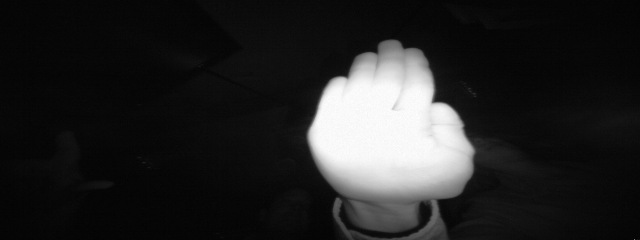

In [11]:
img_sample = Image.open(pics[42])
print(f"Shape: {np.array(img_sample).shape}")

img_sample

In [12]:
path_sample = '/content/drive/MyDrive/leapGestRecog/leapGestRecog/07/10_down/frame_07_10_0091.png'

path_sample.split('/')[-2], path_sample.split('/')[-2][3:]

('10_down', 'down')

In [13]:
classes = [path.split('/')[-2] for path in pics]
labels = [int(lbl.split('_')[0])-1 for lbl in classes]

print(f"Path example: {pics[5432]}, \nClass_name: {classes[5432]}, \nLabel: {labels[5432]}")
print(f"Number of images: {len(pics)}, \nNumber of labels: {len(labels)}")

Path example: /content/drive/MyDrive/leapGestRecog/leapGestRecog/02/08_palm_moved/frame_02_08_0020.png, 
Class_name: 08_palm_moved, 
Label: 7
Number of images: 20090, 
Number of labels: 20090


In [14]:
labels_dict = {int(lbl.split('_')[0]) - 1: lbl[3:] for lbl in classes}
labels_dict 

{0: 'palm',
 1: 'l',
 2: 'fist',
 3: 'fist_moved',
 4: 'thumb',
 5: 'index',
 6: 'ok',
 7: 'palm_moved',
 8: 'c',
 9: 'down'}

Посмотрим на число экземпляров каждого класса в датасете

In [15]:
for num in labels_dict:
  print(f"{labels_dict[num]}: {labels.count(num)}")

palm: 2000
l: 2000
fist: 2000
fist_moved: 2090
thumb: 2000
index: 2000
ok: 2000
palm_moved: 2000
c: 2000
down: 2000


У нас практически одинаковое количество картинок каждого класса. 
Разделим датасет на обучающую и вылидационную выборку

In [16]:
train_pics, test_pics, train_labels, test_labels = train_test_split(pics, labels, test_size=0.25, random_state=42)
len(train_pics), len(train_labels), len(test_pics), len(test_labels)

(15067, 15067, 5023, 5023)

Создадим класс датасета

In [17]:
class GestureDataset(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, init_classes, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform
        self.classes = init_classes

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):

        img = Image.open(self._base_dataset[idx])
        if self.transform is not None:
            img = self.transform(img)

        label = self.classes[idx]

        return img, label

In [18]:
transformer_train = tt.Compose([tt.Grayscale(num_output_channels=1),
                                tt.Resize((80, 80)),
                                tt.RandomApply(torch.nn.ModuleList([tt.RandomRotation(20), tt.RandomHorizontalFlip()]), p=0.5),
                                tt.RandomCrop((50, 50), padding=2),
                                # tt.RandomRotation(30),
                                tt.ToTensor()])


transformer_test = tt.Compose([tt.Grayscale(num_output_channels=1),
                                tt.Resize((50, 50)),
                                tt.ToTensor()])

In [19]:
train_dataset = GestureDataset(train_pics, train_labels, transformer_train)
test_dataset = GestureDataset(test_pics, test_labels, transformer_test)

Определим размер батча и создадим даталоадеры

In [20]:
batch_size = 200

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1, shuffle=False)

Функция для просмотра случайных картинок из получившегося датасета:

In [21]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 50, 50])


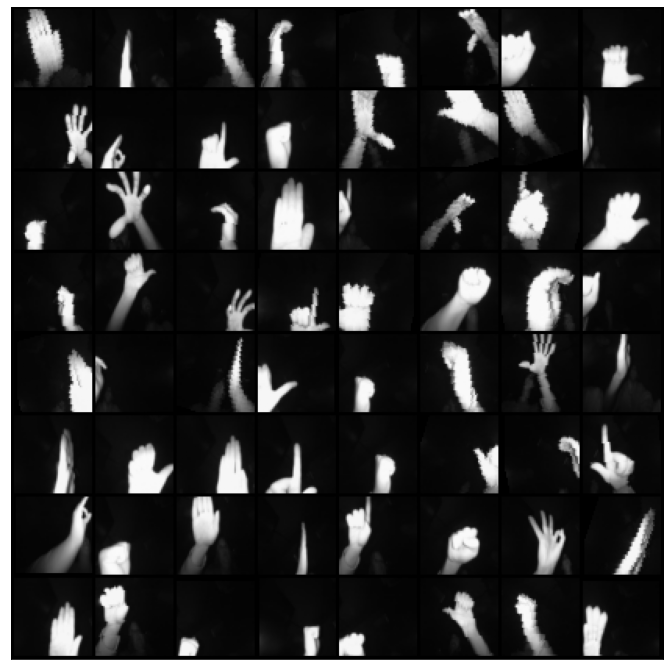

In [22]:
show_batch(train_dataloader)

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(5), 
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [20]:
model = ResNet(1, len(labels_dict)).to(device)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [21]:
epochs = 50
max_lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), max_lr)

epoch_losses = []
accuracy_list_test = []

for epoch in range(epochs):
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
    test_running_loss = 0
    test_epoch_loss = []
    torch.cuda.empty_cache()
    accuracy = running_right / running_items

    test_running_right, test_running_total = 0.0, 0.0
    for batch_idx, (data, labels) in enumerate(test_dataloader):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
                
        test_running_loss += loss.item()
        test_epoch_loss.append(loss.item())
        test_running_total += len(labels)
        test_running_right += (labels == torch.max(outputs, 1)[1]).sum()

    accuracy_test = test_running_right / test_running_total
    
    if epoch > 0 : 
        if  accuracy_test > max(accuracy_list_test):
            torch.save(model, '/content/drive/MyDrive/leapGestRecog/model.pth')
            print("New model saved!")

    accuracy_list_test.append(accuracy_test)
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Loss: {np.mean(epoch_loss)}. ' \
          f'Accuracy: {accuracy:.3f}. ' \
          f'Accuracy_test: {accuracy_test:.3f}', sep='\n')
    epoch_losses.append(epoch_loss)

Epoch [1/50]. Loss: 5.926125855822312. Accuracy: 0.191. Accuracy_test: 0.129
New model saved!
Epoch [2/50]. Loss: 2.2334868751074137. Accuracy: 0.174. Accuracy_test: 0.149
New model saved!
Epoch [3/50]. Loss: 1.709122900900088. Accuracy: 0.387. Accuracy_test: 0.303
New model saved!
Epoch [4/50]. Loss: 1.2018613431014513. Accuracy: 0.572. Accuracy_test: 0.542
New model saved!
Epoch [5/50]. Loss: 0.6905700517328162. Accuracy: 0.762. Accuracy_test: 0.631
New model saved!
Epoch [6/50]. Loss: 0.41413355422647374. Accuracy: 0.864. Accuracy_test: 0.680
New model saved!
Epoch [7/50]. Loss: 0.30402615685996254. Accuracy: 0.897. Accuracy_test: 0.750
New model saved!
Epoch [8/50]. Loss: 0.22197367995977402. Accuracy: 0.926. Accuracy_test: 0.782
Epoch [9/50]. Loss: 0.18972238908080677. Accuracy: 0.939. Accuracy_test: 0.771
New model saved!
Epoch [10/50]. Loss: 0.1747165000752399. Accuracy: 0.942. Accuracy_test: 0.785
New model saved!
Epoch [11/50]. Loss: 0.1452874149146833. Accuracy: 0.952. Accura

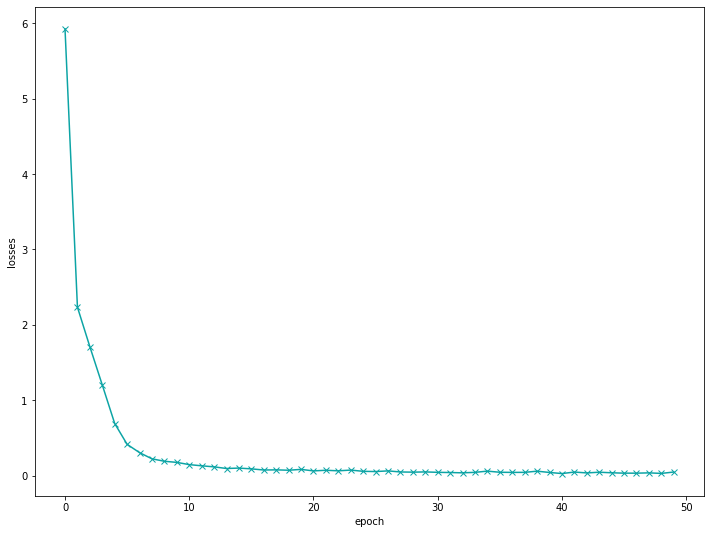

In [24]:
plt.figure(figsize=(12, 9))
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x', color='#0CA4A5')
plt.xlabel('epoch')
plt.ylabel('losses');

Видно, что удалось очень хорошо снизить ошибку и существенно улучшить качество модели. При этом сохранялась модель, которая дала наилучший результат

Теперь загрузим модель, чтобы ее использовать дальше в скрипте. Сразу прогоним через нее тестовый датасет

In [6]:
net = torch.load('/content/drive/MyDrive/leapGestRecog/model.pth')
net.eval()

ResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

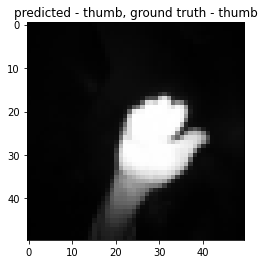

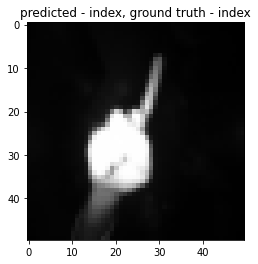

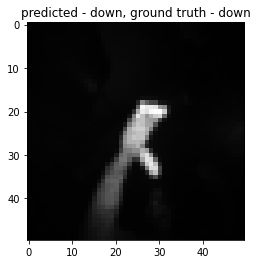

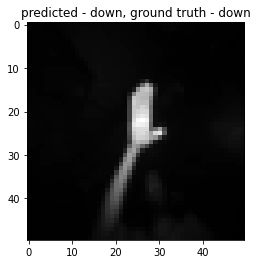

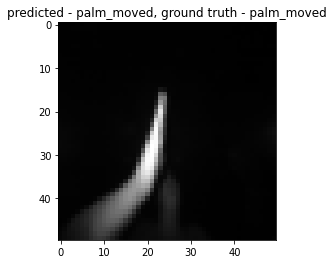

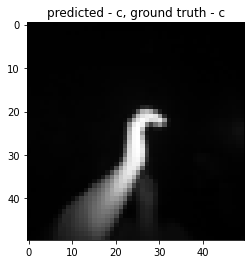

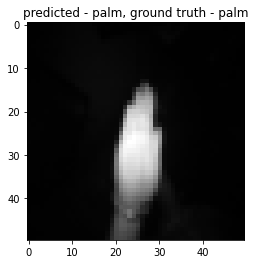

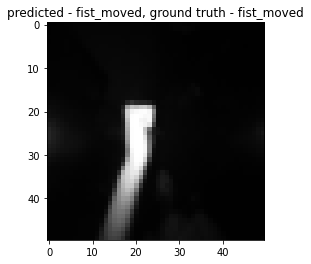

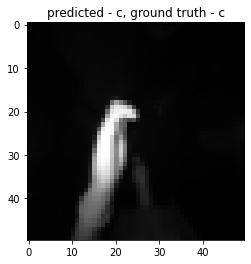

In [37]:
with torch.no_grad():
  for i, data in enumerate(test_dataloader, 3):
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(images)
        plt.title(f'predicted - {labels_dict[int(outputs[0].argmax())]}, ground truth - {labels_dict[int(labels[0])]}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break

Вдно, что модель хорошая, хорошо отделяет классы и возвращает правильные ответы. Теперь сделаем модель, которая будет при обнаруженнии лица считывать жест. Ждя этого нам нужна модель детекции лица

In [23]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


Подключим встроенную камеру для получения фото

In [24]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


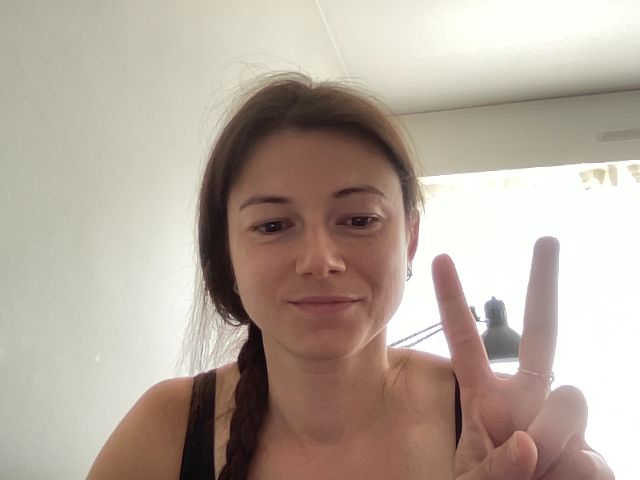

In [37]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Камера подключена!

In [51]:
def predict_gesture():
  
    with torch.no_grad():
      img = take_photo()
      display(Image(img))
      img = cv2.imread(img)
      
      transform = tt.Compose([tt.ToPILImage(),
                              tt.Grayscale(num_output_channels=1),
                              tt.Resize((50, 50)),
                              tt.ToTensor()])
      img = transform(img).unsqueeze(1)
      # img.to(device)
      outputs = net(img.to(device))
      print(f'predicted - {labels_dict[int(outputs[0].argmax())]}')


<IPython.core.display.Javascript object>

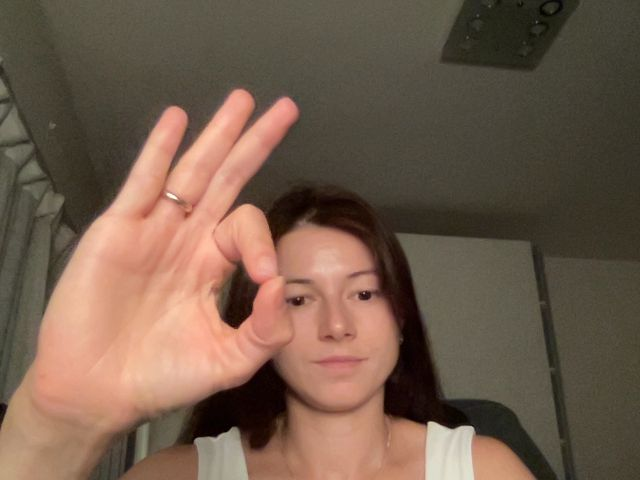

predicted - ok


In [63]:
predict_gesture()

In [ ]:
def filter_photo():

      img = take_photo()
      display(Image(img))
      img = cv2.imread(img)

      np.array()
      
      transform = tt.Compose([tt.ToPILImage(),
                              tt.Grayscale(num_output_channels=1),
                              tt.Resize((50, 50)),
                              tt.ToTensor()])
      img = transform(img).unsqueeze(1)
      # img.to(device)
      outputs = net(img.to(device))
      print(f'predicted - {labels_dict[int(outputs[0].argmax())]}')

In [94]:
import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

    
class FaceDetector(object):
    """
    Face detector class
    """

    def __init__(self, mtcnn):
        self.mtcnn = mtcnn
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.emodel = torch.load('/content/drive/MyDrive/leapGestRecog/model.pth')
        self.emodel.eval()

    def _draw(self, frame, boxes, probs, gestures):
        """
        Draw landmarks and boxes for each face detected
        """
        try:
            for box, prob, gesture in zip(boxes, probs, gestures):
                # Draw rectangle on frame
                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 153, 255), thickness=1)

                # Show probability
                cv2.putText(frame, gesture, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)

                # Draw landmarks
                # cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                # cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                # cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                # cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                # cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            pass

        return frame
    
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            # plt.imshow(frame[int(box[1]):int(box[3]), int(box[0]):int(box[2])])
            # plt.show()
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces
    
    @staticmethod
    def digit_to_classname(digit):
        if digit == 0:
            return 'palm'
        elif digit == 1:
            return 'l'
        elif digit == 2:
            return 'fist'
        elif digit == 3:
            return 'fist_moved'
        elif digit == 4:
            return 'thumb'
        elif digit == 5:
            return 'index'
        elif digit == 6:
            return 'ok'
        elif digit == 7:
            return 'palm_moved'
        elif digit == 8:
            return 'c'
        elif digit == 9:
            return 'down'


    def run(self):
        """
            Run the FaceDetector and draw landmarks and boxes around detected faces
        """                
        frame = cv2.imread(take_photo())
              
        # detect face box, probability and landmarks
        boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
        print(boxes)

        faces = self.crop_faces(frame, boxes)
        gestures = []
        if faces:

      
          transform = tt.Compose([tt.ToPILImage(),
                                  tt.Grayscale(num_output_channels=1),
                                  tt.Resize((50, 50)),
                                  tt.ToTensor()])
          
          img = transform(frame).unsqueeze(1)
          gesture = self.emodel(img.to(device))
          gesture = self.digit_to_classname(gesture.argmax())
          gestures.append(gesture)

          # img.to(device)
          print(f'predicted - {gesture}')



            # frame_for_model = self.transform_frame(frame)
            # gesture = self.gestmodel(frame_for_model)
            # gesture = self.num_to_classname(gesture.argmax())
            # self.reactions_to_gestures(gesture)

        # draw on frame
        self._draw(frame, boxes, probs, gestures)

        if gestures[0] == 'palm':
          print("Woow it's palm!")
        elif gestures[0] == 'thumb':
          print("It's thumb again.....")
        elif gestures[0] == 'fist':
          print("I'm not shure it's first.....?")
        elif gestures[0] == 'down':
          print("Down.....?") 
        else:
          print("Something else.....")
    
        # Show the frame
        cv2.imwrite('Face_Detection.png', frame)
        plt.figure(figsize=(20, 10))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()
        
        
# Run the app
mtcnn = MTCNN()
fcd = FaceDetector(mtcnn)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[[214.64069 182.03403 339.45184 333.3823 ]]
predicted - c
Something else.....


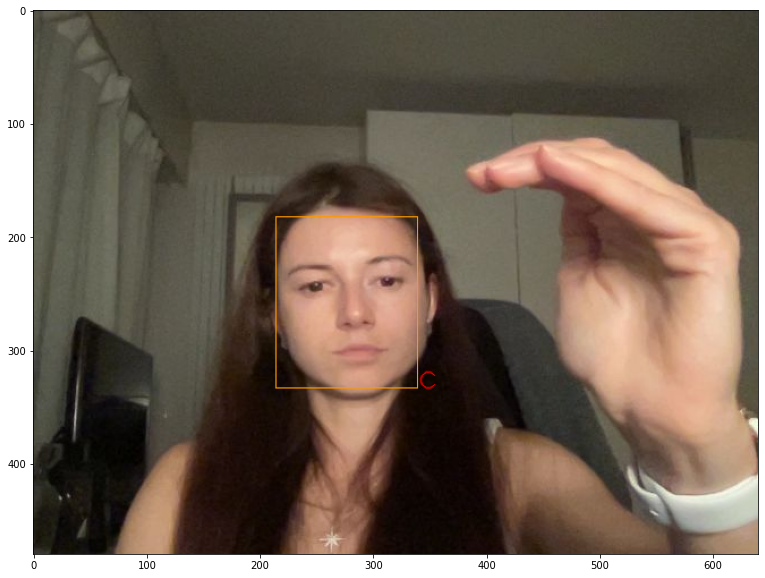

In [96]:
fcd.run()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[[394.6247  224.01819 499.59894 350.3938 ]]
predicted - down
Down.....?


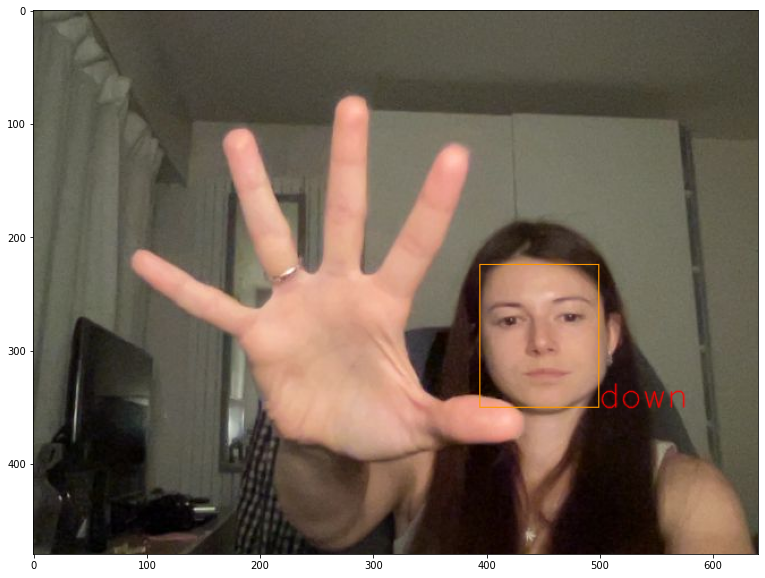

In [103]:
fcd.run()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[[342.782   186.80379 457.89908 323.7011 ]]
predicted - ok
Something else.....


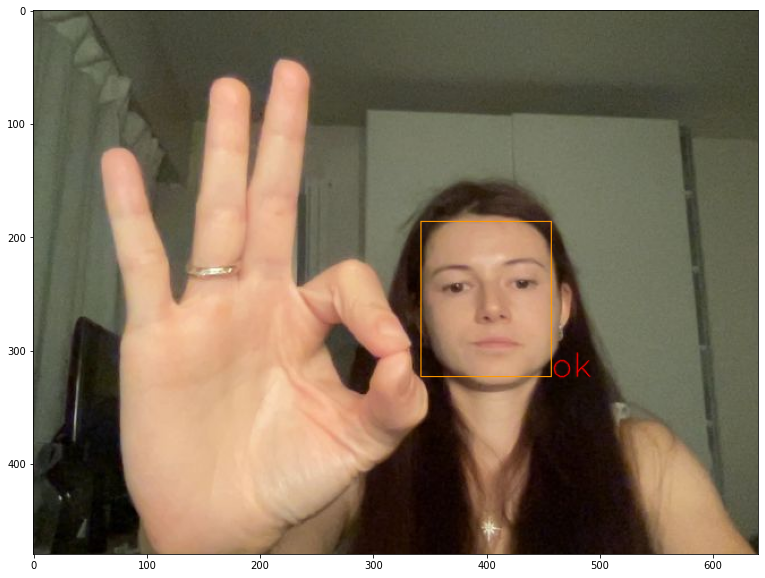

In [105]:
fcd.run()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[[243.31026 199.60602 360.2157  341.12982]]
predicted - down
Down.....?


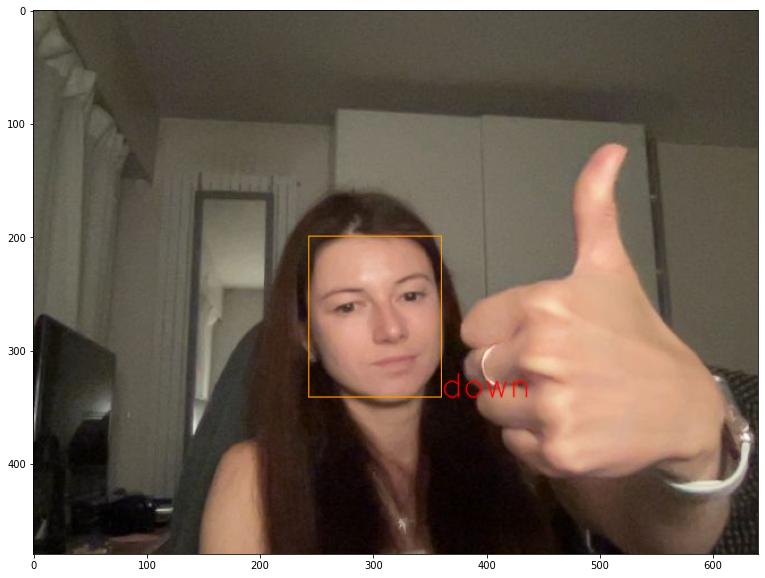

In [107]:
fcd.run()

Модель очень хорошо работает на тесовых данных, но совместно с моделью детекции лица работает немного хуже из-за того, что что лицо имеет такой же цвет и яркость - модель путается